https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

# Imports

In [0]:
from __future__ import print_function
import numpy as np
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from torchvision.utils import save_image

Version 1.3.1
CUDA enabled: True


# Segmentation Model

Call get_segmented_image to get a tensor containing a predicted class per pixel

In [0]:
# We're gonna start w/ a pretrained model and then perhaps if we're feeling up to it we can architect/train our own
segmentation_model = torch.hub.load('pytorch/vision:v0.4.2', 'deeplabv3_resnet101', pretrained=True)
segmentation_model.eval()

imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

imsize = (imsize, imsize)

def get_segmented_image(input_image):
    # First we want to preprocess the image to be ingested by the network
    
    preprocess = transforms.Compose([
        transforms.Resize(imsize),  # scale imported image
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        segmentation_model.to('cuda')

    with torch.no_grad():
        output = segmentation_model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # WORK FROM THIS POINT ON SEGMENTATION STYLING

    # At this point, output_predictions is a single channel tensor with the same
    # dimensions as the input image. Each pixel will either be 0 indicating that it
    # is part of the background or it will be an int between 1-20 representing which
    # class that pixel belongs to (cat, dog, person, etc.).

    # If we have multiple style images, we can map each predicted class/background in
    # output_predictions to a certain style and for each styled image only fill in the
    # resulting image where its mapped class appears in output_predictions.
    return output_predictions

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 109MB/s]
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


# Define stylizing network

In [0]:
# TODO: Get a GPU for this (??)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# Erik: Try forcing the image size to be squares so we don't need to manually resize.
imsize = (imsize, imsize)

# Erik: We've seen this before in DL colabs
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

unloader = transforms.ToPILImage()  # reconvert into PIL image

def image_loader(image_name):
    image = Image.open(image_name)
    # print('original size', image.size())
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None, save=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    pltimage = unloader(image)
    plt.imshow(pltimage)
    plt.axes().set_axis_off()
    if title is not None:
        plt.title(title)
    if save is not None:
        save_image(image, save)
        #plt.savefig(save, transparent=True)
    plt.pause(2) # pause a bit so that plots are updated

def style_segments(segmented_img, class_to_styles):
    segmented_np = segmented_img.cpu().numpy()
    channels = class_to_styles[0].shape[0] if len(class_to_styles[0].shape) == 3 else class_to_styles[0].shape[1]
    output_np = np.zeros((channels, segmented_np.shape[0], segmented_np.shape[1]), dtype=np.float32)
    imshow(torch.from_numpy(output_np), save='start.png')
    for class_num, style in class_to_styles.items():
        style = style.cpu().detach().numpy()
        if len(style.shape) == 4:
            style = style[0]
        output_np = np.where(segmented_np == class_num, style, output_np)
        imshow(torch.from_numpy(output_np), save='halfway.png')
    return torch.from_numpy(output_np).view(1, channels, segmented_np.shape[0], segmented_np.shape[1])

################################################################################

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class MultiStyleLoss(nn.Module):

    def __init__(self, target_feature_1, target_feature_2, weight):
        super(MultiStyleLoss, self).__init__()
        self.target1 = gram_matrix(target_feature_1).detach()
        self.target2 = gram_matrix(target_feature_2).detach()
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = self.weight * F.mse_loss(G, self.target1) + (1 - self.weight) *  F.mse_loss(G, self.target2)
        return input

class MultipleStyleLoss(nn.Module):
    
    def __init__(self, target_features, weight):
        super(MultipleStyleLoss, self).__init__()
        if weight is None or not isinstance(weight, list):
            weight = [1 / len(target_features)] * len(target_features)
        assert(len(target_features) == len(weight))
        self.targets = []
        for target_feature in target_features:
            self.targets.append(gram_matrix(target_feature).detach())
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = 0
        for i in range(len(self.targets)):
            self.loss += self.weight[i] * F.mse_loss(G, self.targets[i])
        return input

class SegmentationStyleLoss(nn.Module):
    
    def __init__(self, target_features, segmentation):
        super(SegmentationStyleLoss, self).__init__()
        self.targets = []
        for target_feature in target_features:
            self.targets.append(target_feature.clone())
        self.segmentation = segmentation
        self.segmentation_classes = torch.unique(segmentation)

    def forward(self, input):
        G = gram_matrix(input)
        class_to_styles = {}
        for i in range(len(self.segmentation_classes)):
            class_to_styles[self.segmentation_classes[i].item()] = self.targets[i].clone()
        segmented_target = style_segments(self.segmentation, class_to_styles)

        self.loss = F.mse_loss(G, gram_matrix(segmented_target).to(device))
        return input


cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               multi_style_weight,
                               segmentation=None,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            if segmentation is not None:
                target_features = []
                for style in style_img:
                    target_features.append(model(style).detach())
                style_loss = SegmentationStyleLoss(target_features, segmentation)
            elif isinstance(style_img, list):
                target_features = []
                for style in style_img:
                    target_features.append(model(style).detach())
                style_loss = MultipleStyleLoss(target_features, multi_style_weight)
            else:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss) or \
        isinstance(model[i], MultiStyleLoss) or isinstance(model[i], MultipleStyleLoss) or \
        isinstance(model[i], SegmentationStyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

################################################################################

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       multi_style_weight = None,
                       segmentation=None,
                       num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        multi_style_weight, segmentation)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 105MB/s]


# Define stylizing methods

In [0]:
# Takes in list of filenames and returns a list of those files
def get_style_images(filenames):
    ret = []
    for filename in filenames:
        ret.append(image_loader(filename))
    return ret

def get_content_and_segmented_image(filename):
    content_img = image_loader(filename)
    segmented_img = get_segmented_image(Image.open(filename))
    segmented_classes = torch.unique(segmented_img)
    return content_img, segmented_img, segmented_classes

# Apply stylizing from each style image and apply the style to segments

colors.jpg    monet.jpg  roses.jpg    selfie.jpg
low_poly.png  ny.jpg	 sample_data  starry.jpg
tensor([ 0, 15], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


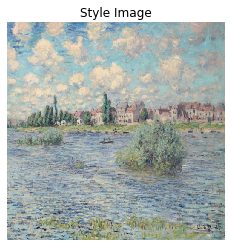

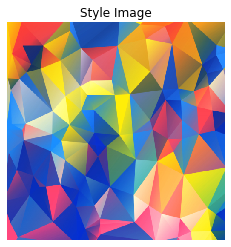

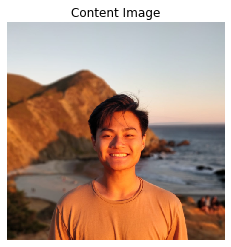

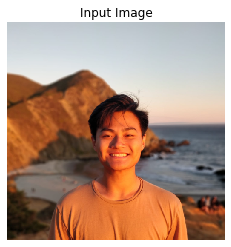

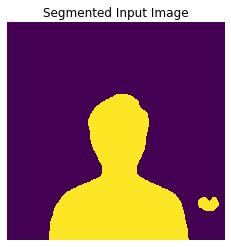

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


run [50]:
Style Loss : 53.561325 Content Loss: 14.050579

run [100]:
Style Loss : 10.234052 Content Loss: 13.263395

run [150]:
Style Loss : 5.326877 Content Loss: 11.721696

run [200]:
Style Loss : 3.947268 Content Loss: 10.523172

run [250]:
Style Loss : 2.850952 Content Loss: 9.763759

run [300]:
Style Loss : 1.945450 Content Loss: 9.294730

run [350]:
Style Loss : 1.296521 Content Loss: 8.952417



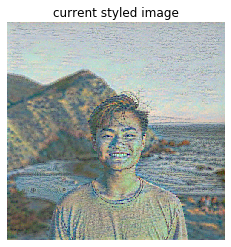

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1115.468262 Content Loss: 15.632205

run [100]:
Style Loss : 367.870819 Content Loss: 17.217007

run [150]:
Style Loss : 171.987701 Content Loss: 18.787474

run [200]:
Style Loss : 73.711990 Content Loss: 19.004856



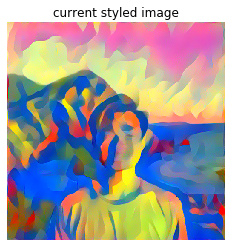

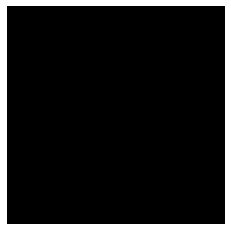

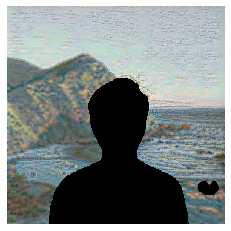

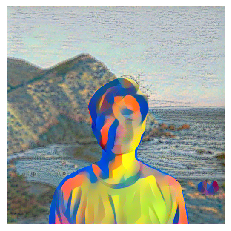

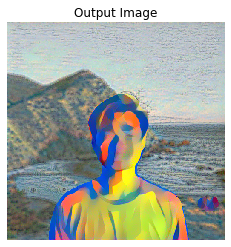

In [0]:
NOISY_START = False
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = (350, 200)
!ls

style_imgs = get_style_images(["monet.jpg", "low_poly.png"])
content_img, segmented_img, segmented_classes = get_content_and_segmented_image("selfie.jpg")
print(segmented_classes)

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()

    for img in style_imgs:
        imshow(img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image',save='input.png')

    plt.figure()
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    r = Image.fromarray(segmented_img.byte().cpu().numpy()).resize(Image.open("selfie.jpg").size)
    r.putpalette(colors)
    image = loader(r).unsqueeze(0)
    imshow(image.to(device, torch.float), title='Segmented Input Image', save='naiveseg_segment.png')



class_to_styles = {}

for i in range(len(segmented_classes)):
    class_to_styles[segmented_classes[i].item()] = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs[i % len(style_imgs)], input_img, multi_style_weight=STYLE_WEIGHT,
                            num_steps=ITERATIONS[i], style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT).clone()
    imshow(class_to_styles[segmented_classes[i].clone().item()], title='current styled image')

output = style_segments(segmented_img, class_to_styles)

plt.figure()
imshow(output, title='Output Image', save='output.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Stitch Style images according to segmentation, and then use stitched style image and content image as normal

low_poly.png  output.png  roses.jpg  sample_data  selfie.jpg  starry.jpg
torch.Size([1, 3, 512, 512])
Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Optimizing..
run [50]:
Style Loss : 156.470718 Content Loss: 13.964474

run [100]:
Style Loss : 48.513863 Content Loss: 14.256860

run [150]:
Style Loss : 18.521152 Content Loss: 13.859903

run [200]:
Style Loss : 10.055428 Content Loss: 12.966348

run [250]:
Style Loss : 6.222975 Content Loss: 12.090936

run [300]:
Style Loss : 4.253518 Content Loss: 11.442826

run [350]:
Style Loss : 2.948769 Content Loss: 10.979145

run [400]:
Style Loss : 2.248729 Content Loss: 10.530066

run [450]:
Style Loss : 1.774227 Content Loss: 10.186462

run [500]:
Style Loss : 1.495395 Content Loss: 9.908221



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


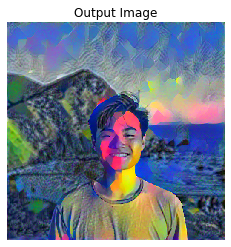

In [0]:
NOISY_START = True
SHOW_INPUT = False

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = 500
!ls

style_imgs = get_style_images(["starry.jpg", "low_poly.png"])
content_img, segmented_img, segmented_classes = get_content_and_segmented_image("selfie.jpg")

# Build stitched style image first
class_to_styles = {}
for i in range(len(segmented_classes)):
    class_to_styles[segmented_classes[i].item()] = style_imgs[i]
stitched_style_img = style_segments(segmented_img, class_to_styles).to(device, torch.float)
print(stitched_style_img.shape)

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(stitched_style_img, title='Stitched Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, stitched_style_img, input_img, multi_style_weight=STYLE_WEIGHT,
                            num_steps=ITERATIONS, style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT).clone()

plt.figure()
imshow(output, title='Output Image', save='output.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

# Defining a custom Loss function that takes Segmentation into account

In [0]:
NOISY_START = True
SHOW_INPUT = False

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
ITERATIONS = 100
!ls

style_imgs = get_style_images(["starry.jpg", "low_poly.png"])
content_img, segmented_img, _ = get_content_and_segmented_image("selfie.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.1)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    imshow(stitched_style_img, title='Stitched Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, input_img, segmentation=segmented_img,
                            num_steps=ITERATIONS, style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT).clone()

plt.figure()
imshow(output, title='Output Image', save='output.png')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

low_poly.png  output.png  roses.jpg  sample_data  selfie.jpg  starry.jpg
Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: ignored

# N-Styles Multistyle

In [0]:
NOISY_START = False
SHOW_INPUT = True

STYLE_WEIGHT = 1000000
CONTENT_WEIGHT = 1
MULTISTYLE_WEIGHT = [0.2, 0.4, 0.4]
ITERATIONS = 600
!ls
content_img = image_loader("selfie.jpg")
style_imgs = [image_loader("low_poly.png"), image_loader("starry.jpg")]
# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

input_img = content_img.clone()
if NOISY_START:
    input_img = torch.normal(content_img.data, 0.01)
    input_img.data.clamp_(0, 1)

plt.ion()

if SHOW_INPUT:
    plt.figure()
    for img in style_imgs:
        imshow(img, title='Style Image')

    plt.figure()
    imshow(content_img, title='Content Image')

    plt.figure()
    imshow(input_img, title='Input Image')


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, input_img, None, multi_style_weight=MULTISTYLE_WEIGHT,
                            num_steps=ITERATIONS, style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT)
plt.figure()
imshow(output, title='Output Image', save='output.png')

colors.jpg    monet.jpg  roses.jpg    selfie.jpg
low_poly.png  ny.jpg	 sample_data  starry.jpg


NameError: ignored